In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold
# from sklearn.linear_model import LinearRegression, SGDClassifier, RidgeClassifier
# from sklearn.svm import SVC
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import AdaBoostClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.neural_network import MLPClassifier

from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint

os.environ['CUDA_VISIBLE_DEVICES']='2' # 使用编号为2号的GPU

Using TensorFlow backend.


In [2]:
def model_train(train_x, train_y, hidden_nodes, activation, epochs):
    '''
    训练单个神经网络，返回网络model。
    3层，隐藏层节点数默认和输入数据特征数相等，输出层单个节点。
    '''
    model = Sequential()
    model.add(Dense(hidden_nodes, activation=activation, input_shape=(train_x.shape[1],)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='mse', optimizer='adam')
    model.fit(train_x, train_y, epochs=epochs, verbose=0)
    return model

def resample_with_replacement(X_train, y_train, sample_weight):
    '''
    加权重采样，输入数据和权重，输出新采样数据。
    '''
    # normalize sample_weights if not already
    sample_weight = sample_weight / sample_weight.sum(dtype=np.float64)
    X_train_resampled = np.zeros(X_train.shape, dtype=np.float32)
    y_train_resampled = np.zeros(y_train.shape, dtype=np.int)
    for i in range(len(X_train)):
        # draw a number from 0 to len(X_train)-1
        draw = np.random.choice(np.arange(X_train.shape[0]), p=sample_weight)
        # place the X and y at the drawn number into the resampled X and y
        X_train_resampled[i] = X_train[draw]
        y_train_resampled[i] = y_train[draw]

    return X_train_resampled, y_train_resampled

def judge_y(pred_y, threshold=0.5):
    '''
    把结果的概率转化为分类结果，大于0.5归为正类，小于等于0.5归为反类。
    '''
    p_y = np.zeros(pred_y.shape, dtype=bool)
    for i in range(pred_y.shape[0]):
        if pred_y[i] > threshold:
            p_y[i] = True
        else:
            p_y[i] = False
    return p_y
    
    
def print_wrong(pred_y, test_y, is_print=False):
    '''
    输出各类指标，返回 pred_y != test_y 的下标。
    '''
    p_y = judge_y(pred_y, threshold=0.5)
    t_y = test_y.astype(bool)
    true_positive     = np.sum(p_y & t_y)   # 正例判对
    true_negative     = np.sum(~p_y & ~t_y) # 反例判对
    false_negative    = np.sum(~p_y & t_y)  # 正例判错 一类错误
    false_positive    = np.sum(p_y & ~t_y)  # 反例判错 二类错误
    
    error             = false_positive + false_negative
    error_rate        = error / test_y.shape[0]
    pulsar_error      = false_negative
    pulsar_error_rate = pulsar_error / (true_positive + false_negative)
    rfi_error         = false_positive
    rfi_error_rate    = rfi_error / (true_negative + false_positive)
    
    accuracy = (true_positive + true_negative) / test_y.shape[0]  # 总体准确率       
    precision = true_positive / (true_positive + false_positive)  # 找到多少正例
    recall = true_positive / (true_positive + false_negative)     # 判为正例的可靠程度
    FPR = false_positive / (false_positive + true_negative)       # 漏判正例的比例
    G_Mean = (recall * (1 - FPR))**0.5
    f_score = 2 * ((precision * recall) / (precision + recall)) 
    
    if is_print:
        print('     错误：%d / %d，%.2f%%' % (error, test_y.shape[0], error_rate * 100))
        print('  一类拒真：%d / %d，%.2f%%' % (pulsar_error, (true_positive + false_negative), pulsar_error_rate * 100))
        print('  二类纳伪：%d / %d，%.2f%%' % (rfi_error, (true_negative + false_positive), rfi_error_rate * 100))
        
        print(" accuracy: %.4f" % accuracy)
        print("   recall: %.4f" % recall)
        print("precision: %.4f" % precision)
        print("      FPR: %.4f" % FPR)
        print("   G-Mean: %.4f" % G_Mean)
        print("  f-score: %.4f" % f_score)
    return p_y != test_y
    
def plot_wrong(pred_y, test_y, savefig=''):
    '''
    画出结果分布图，黑点为分类正确，红点为分类错误，点越靠上，模型把它归为正类的信心越大，反之归为反类信心越大。
    '''
    p_y = judge_y(pred_y, threshold=0.5)
    legend = []
    fig, ax = plt.subplots(3, figsize=(int(np.log10(test_y.shape[0])) + 4, 5), sharey=True)
    ax[0] = plt.subplot2grid((5, 6), (0, 0), colspan=5, rowspan=4)
    ax[1] = plt.subplot2grid((5, 6), (0, 5), rowspan=4)
    
    
    index = np.array((1 - test_y) * (1 - p_y), dtype=bool) # TN
    argindex = np.argwhere((1 - test_y) * (1 - p_y))
    if index.any():
        ax[0].plot(argindex, pred_y[index], 'k.')
        legend.append('TN')
    index = np.array(test_y * p_y, dtype=bool)  # TP
    argindex = np.argwhere(test_y * p_y)
    if index.any():
        ax[0].plot(argindex, pred_y[index], 'k*')
        legend.append('TP')
        
        
        
    index = np.array(test_y == p_y, dtype=bool)
    ax[1].hist(pred_y[index], np.linspace(0, 1, 21), weights=[1/index.sum()] * index.sum(), color='k', alpha=0.5, orientation='horizontal')
        
        
    index = np.array((1 - test_y) * p_y, dtype=bool)  # FP
    argindex = np.argwhere((1 - test_y) * p_y)
    if index.any():
        ax[0].plot(argindex, pred_y[index], 'r.')
        legend.append('FP')
        ax[1].hist(pred_y[index], np.linspace(0, 1, 21), weights=[1/index.sum()] * index.sum(), color='b', alpha=0.5, orientation='horizontal')
    index = np.array(test_y * (1 - p_y), dtype=bool)  # FN
    argindex = np.argwhere(test_y * (1 - p_y))
    if index.any():
        ax[0].plot(argindex, pred_y[index], 'r*')
        legend.append('FN')
        ax[1].hist(pred_y[index], np.linspace(0, 1, 21), weights=[1/index.sum()] * index.sum(), color='r', alpha=0.5, orientation='horizontal')
    
    ax[0].set_ylim([0, 1])
    ax[0].set_xlim(0, pred_y.shape[0])
    ax[0].legend(legend, loc='upper right')
    
    ax[1].set_ylim([0, 1])
    ax[1].set_xlim([0, 1])
    plt.setp(ax[1].get_yticklabels(), visible=False) # 隐藏y轴刻度
    plt.tight_layout()                               # 子图紧靠
    plt.subplots_adjust(wspace=0, hspace=0)
    if savefig != '':
        fig.set_rasterized(True)
        plt.savefig('figures/%s' % savefig, dpi=200)
    plt.show()
    

def adaboost_nn_train(x_train, y_train, hidden_nodes, activation, epochs, n_estimator):
    '''
    以神经网络为弱学习器的Adaboost模型训练，返回所有弱学习器组成的 model_list 和对应的权重列表 alpha_list。
    '''
    model_list = []
    alpha_list = []
    sample_weight = np.ones([x_train.shape[0]], dtype=np.float64) / x_train.shape[0]
    
    while(len(model_list) < n_estimator):
        x_train_resampled, y_train_resampled = resample_with_replacement(x_train, y_train, sample_weight)
        model = model_train(x_train_resampled, y_train_resampled, hidden_nodes, activation, epochs)
        y = model.predict(x_train).reshape([-1])
        wrong_index = print_wrong(y, y_train)
        error_rate = np.sum(sample_weight[wrong_index]) # 这里的错误率是加权的错误率。
        if error_rate >= 0.5:
            print('错误率太高，舍弃该弱学习器，重置权重。')
            sample_weight = np.ones([x_train.shape[0]], dtype=np.float64) / x_train.shape[0]
            continue
        model_list.append(model)
        alpha = 1 / 2 * np.log((1 - error_rate) / (error_rate + 1e-8)) # 避免出现全对学习器造成除以错误率0的错误，分母加上1e-8
        alpha_list.append(alpha)
        wrong_index[wrong_index == 0] = -1                          # 把0变-1，方便后面调整权重。
        sample_weight = sample_weight * np.exp(alpha * wrong_index) # 权重调整公式，这里1是错误，所以前面不加负号。
        sample_weight /= sample_weight.sum()
    return model_list, alpha_list

def adaboost_nn_predict(x_test, y_test, model_list, alpha_list):
    '''
    Adaboos模型预测，返回预测值。
    '''
    y_sum = np.zeros(y_test.shape, dtype=float)
    for i_estimator in range(len(model_list)):
        y_pred = model_list[i_estimator].predict(x_test).reshape([-1])
        y_sum += y_pred * alpha_list[i_estimator]
    y_sum /= np.array(alpha_list).sum()
    return y_sum

In [3]:
# 数据的加载及读取
# data_train, data_test = train_test_split(np.loadtxt("data/HTRU_1_Lyon_Features_(8).csv", dtype=np.float, delimiter=","), train_size=0.7)

# data_train, data_test = train_test_split(np.loadtxt("data/HTRU_2_Lyon_Features_(8).csv", dtype=np.float, delimiter=","), train_size=0.7)

# data_train = np.loadtxt("data/train.csv", dtype=np.float, delimiter=",")
# data_test = np.loadtxt("data/test.csv", dtype=np.float, delimiter=",")

# data_train = np.loadtxt("data/train(1).csv", dtype=np.float, delimiter=",")
# data_test = np.loadtxt("data/test(1).csv", dtype=np.float, delimiter=",")

# data_train, data_test = train_test_split(np.loadtxt("data/LOTAAS_1_Lyon_Features_(8).csv", dtype=np.float, delimiter=","), train_size=0.7)

# data_train = np.loadtxt("data/fast/train.csv", dtype=np.float, delimiter=",")
# data_test = np.loadtxt("data/fast/test.csv", dtype=np.float, delimiter=",")


# 下面三行对应三组30特征数据集。
data_train, data_test = train_test_split(np.loadtxt("data/HTRU_1_Combined_Lyon_Thornton_Features (30).csv", dtype=np.str, delimiter=",")[:-1].astype(np.float), train_size=0.7)
# data_train, data_test = train_test_split(np.loadtxt("data/HTRU_2_Combined_Lyon_Thornton_Features (30).csv", dtype=np.float, delimiter=","), train_size=0.7)
# data_train, data_test = train_test_split(np.loadtxt("data/LOTAAS_1_Combined_Lyon_Thornton_Features (30).csv", dtype=np.float, delimiter=","), train_size=0.7)
    
print('data_train:%s, data_test:%s' % (data_train.shape, data_test.shape))
print('train:%d / %d, test:%d / %d' % (np.sum(data_train[:, -1] == 1), np.sum(data_train[:, -1] == 0), np.sum(data_test[:, -1] == 1), np.sum(data_test[:, -1] == 0)))

data_train:(63833, 31), data_test:(27358, 31)
train:814 / 63019, test:382 / 26976


In [4]:
# 数据预处理
x_train = data_train[:, :-1]
y_train = data_train[:, -1].astype(np.int)
x_test = data_test[:, :-1]
y_test = data_test[:, -1].astype(np.int)

min_max = MinMaxScaler()
x_train = min_max.fit_transform(x_train)
x_test = min_max.transform(x_test)

# PCA能降维，30能降到12左右，稍微加快训练速度。
pca = PCA(0.95)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)
print(x_train.shape, x_test.shape)

(63833, 12) (27358, 12)


(1835, 12) (13581, 12)
hidden_nodes:12, activation:relu, epochs:70, n_estimator:9
     错误：4497 / 13581，33.11%
  一类拒真：33 / 326，10.12%
  二类纳伪：4464 / 13255，33.68%
 accuracy: 0.6689
   recall: 0.8988
precision: 0.0616
      FPR: 0.3368
   G-Mean: 0.7721
  f-score: 0.1153


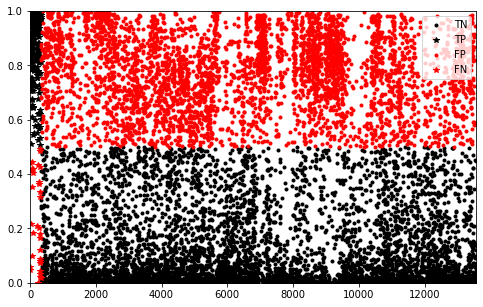

In [4]:
hidden_nodes = [x_train.shape[-1], int(x_train.shape[-1] * 3 / 4), int(x_train.shape[-1] / 2)]
activation = ['relu', 'sigmoid']
epochs = [50, 70]
n_estimator = [7,]

tot_loop = len(hidden_nodes) * len(activation) * len(epochs) * len(n_estimator)
cur_loop = 0

min_error = 1

# 分层k折交叉验证。
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

for hn in hidden_nodes:
    for a in activation:
        for e in epochs:
            for n in n_estimator:
                sum_error = 0
                per = int(np.floor(cur_loop * 25 / tot_loop))
                sys.stdout.write('■' * per + '□' * (25 - per) + '\r')
                sys.stdout.flush()
                for train_index, val_index in skfold.split(x_train, y_train):
                    tmp_x_train = x_train[train_index]
                    tmp_y_train = y_train[train_index]
                    tmp_x_val = x_train[val_index]
                    tmp_y_val = y_train[val_index]

                    model_list, alpha_list = adaboost_nn_train(tmp_x_train, tmp_y_train, hn, a, e, n)
                    tmp_y_pred = adaboost_nn_predict(tmp_x_val, tmp_y_val, model_list, alpha_list)
                    wrong = print_wrong(tmp_y_pred, tmp_y_val)
                    sum_error += wrong.sum() / wrong.shape[0]
                sum_error /= n  # 计算五折平均错误率
                if sum_error < min_error:  # 保留平均错误率最低的参数组合
                    min_error = sum_error
                    best_hn = hn
                    best_a = a
                    best_e = e
                    best_n = n
                cur_loop += 1
    
print('hidden_nodes:%d, activation:%s, epochs:%d, n_estimator:%d' % (best_hn, best_a, best_e, best_n))
model_list, alpha_list = adaboost_nn_train(x_train, y_train, best_hn, best_a, best_e, best_n)
y_pred = adaboost_nn_predict(x_test, y_test, model_list, alpha_list)
print_wrong(y_pred, y_test, is_print=True)
plot_wrong(y_pred, y_test)
    

# standard = StandardScaler()
# x_train = standard.fit_transform(x_train)
# x_test = standard.transform(x_test)

     错误：15 / 27358，0.05%
  一类拒真：11 / 382，2.88%
  二类纳伪：4 / 26976，0.01%
 accuracy: 0.9995
   recall: 0.9712
precision: 0.9893
      FPR: 0.0001
   G-Mean: 0.9854
  f-score: 0.9802


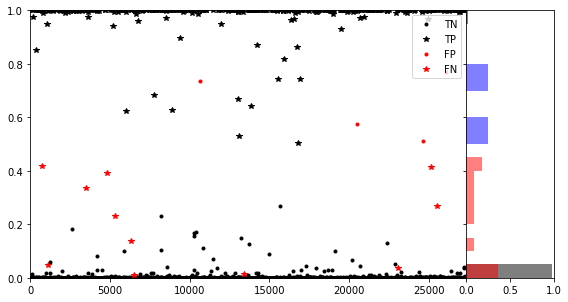

In [5]:
hidden_nodes = x_train.shape[-1]
activation = 'relu'
epochs = 50
n_estimator = 7
model_list, alpha_list = adaboost_nn_train(x_train, y_train, hidden_nodes, activation, epochs, n_estimator)
y_pred = adaboost_nn_predict(x_test, y_test, model_list, alpha_list)
print_wrong(y_pred, y_test, is_print=True)
plot_wrong(y_pred, y_test)


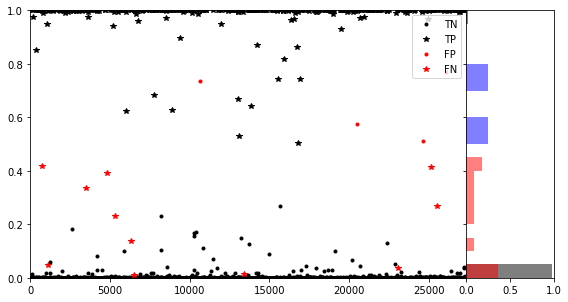

In [6]:
plot_wrong(y_pred, y_test, savefig='HTRU1_0.5.eps')

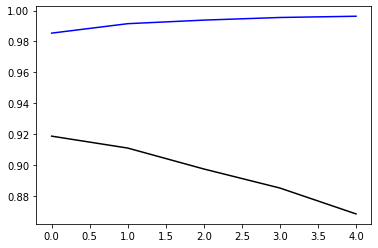

In [29]:
recall = np.array([0.9189, 0.9112, 0.8977, 0.8854, 0.8687])
fpr = np.array([0.0146, 0.0085, 0.0062, 0.0045, 0.0037])
plt.plot(recall, 'k-')
plt.plot(1 - fpr, 'b-')
plt.show()